In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown
from tabulate import tabulate

In this document, we use the particle swarm optimisation (PSO) algorithm to demonstrate the effect of population size on the problem difficulty while fixing the number of cost function evaluations, i.e., the number of generations in this case. 

The Rastrigin function is chosen because the difficulty of finding its maximum rises as its dimension increases.

The Rastrigin function is defined as

$$
f_d(x)=10d+\sum_{i=1}^{d}(x_i^2-10 \cos(2\pi x_i))
$$

where $d$ is the dimension of the function and $x = (x_1, x_2, \ldots, x_d)$ with $x_i \in [-5.12, 5.12]$.

We first visualise the function in two dimensions.


In [2]:
def rastrigin(x):
    return 10 * np.shape(x)[1] + np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x), axis=1)

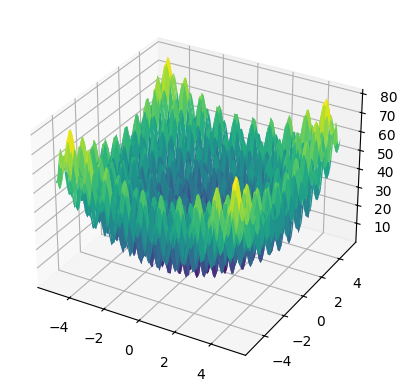

In [3]:
#| label: fig-rastrigin
#| fig-cap: Rastrigin function in 2 dimensions

xlist = np.linspace(-5.12, 5.12, 100)
ylist = np.linspace(-5.12, 5.12, 100)

X, Y = np.meshgrid(xlist, ylist)
Z = 20 + (X ** 2 - 10 * np.cos(2 * np.pi * X)) + (Y ** 2 - 10 * np.cos(2 * np.pi * Y))

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
cp = ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

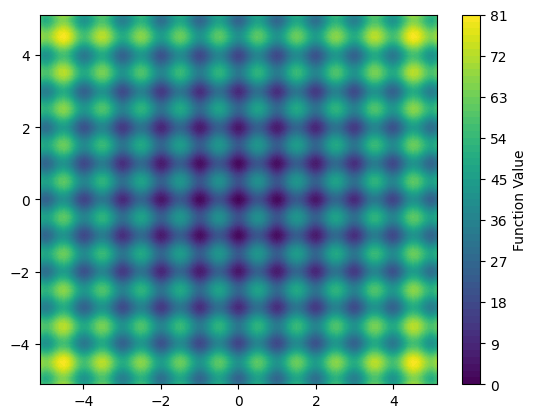

In [4]:
#| label: fig-rastrigin_contour
#| fig-cap: Contour plot of Rastrigin function in 2 dimensions

fig, ax = plt.subplots()
cp = ax.contourf(xlist, ylist, Z, 60, cmap='viridis')
cbar = fig.colorbar(cp, label='Function Value')
plt.show()

As we can see, there are several local minima and maxima in @fig-rastrigin and @fig-rastrigin_contour in the two-dimensional rastrigin function. The theoretical local maximum at the corners of the plot has a function value referring to @tbl-rastrigin_value.


In [5]:
#| label: tbl-rastrigin_value
#| tbl-cap: Global maximal value of Rastrigin function in different dimensions

table = [
  [1, 40.35329019], 
  [2, 80.70658039],
  [3, 121.0598706],
  [4, 161.4131608], 
  [5, 201.7664509], 
  [6, 242.1197412], 
  [7, 282.4730314],
  [8, 322.8263216], 
  [9, 363.1796117]
]
Markdown(tabulate(
  table, 
  headers=['Number of dimensions', 'Maximum value at $\pm 4.523$']
))

  Number of dimensions    Maximum value at $\pm 4.523$
----------------------  ------------------------------
                     1                         40.3533
                     2                         80.7066
                     3                        121.06
                     4                        161.413
                     5                        201.766
                     6                        242.12
                     7                        282.473
                     8                        322.826
                     9                        363.18

In the PSO algorithm, the initial parameters: the number of generations, inertia weight $w$, cognitive weight $\alpha_1$ and social weight $\alpha_2$ are set as followed in the @tbl-initial_parameter.

When the inertia weight, $w$, is set to 0.8, it means that 80% of the particle’s previous velocity is taken into account, while 20% of the adjustments from cognitive and social components are considered. 

Besides, the cognitive weight, $\alpha_1 = 3$ is higher than the social weight, $\alpha_2 = 1$. This encourages the particles to explore the spaces thoroughly rather than converge to the global best-known position.


In [6]:
#| label: tbl-initial_parameter
#| tbl-cap: Initial parameters

GENERATION = 5000
INERTIA = 0.8
ALPHA1 = 2
ALPHA2 = 2
SEARCH_RANGE = 5.12

table = [[GENERATION, INERTIA, ALPHA1, ALPHA2]]
Markdown(tabulate(
  table, 
  headers=['Number of Generations', 'Inertia Weight', 'Cognitive Weight', 'Social Weight']
))

  Number of Generations    Inertia Weight    Cognitive Weight    Social Weight
-----------------------  ----------------  ------------------  ---------------
                   5000               0.8                   2                2

Now, we start to build up the PSO algorithm.


In [7]:
class PSO:
    def __init__(self, dim, population_size, generation=GENERATION, w=INERTIA, a1=ALPHA1, a2=ALPHA2, search_range=SEARCH_RANGE):
        # parameter
        self.w = w
        self.a1 = a1
        self.a2 = a2
        self.dim = dim
        self.search_range = search_range
        self.generation = generation
        self.population_size = population_size

        # particle
        self.particle_pos = np.random.uniform(low=-self.search_range, high=self.search_range, size=(self.population_size, self.dim))
        self.particle_best_pos = self.particle_pos
        self.particle_fitness = rastrigin(self.particle_pos).reshape((self.population_size, -1))

        self.particle_best_fitness = self.particle_fitness
        self.particle_vel = np.random.uniform(low=-1, high=1, size=(self.population_size, dim))

        # swarm
        self.swarm_best_pos = self.particle_pos[np.argmax(self.particle_fitness)]
        self.swarm_best_fitness = np.max(self.particle_fitness)

    def run(self):
        for _ in range(self.generation):
            # move the particles
            a1r1 = self.a1 * np.random.uniform(low=0, high=1, size=(self.population_size, self.dim))
            a2r2 = self.a2 * np.random.uniform(low=0, high=1, size=(self.population_size, self.dim))
            best_particle_dif = self.particle_best_pos - self.particle_pos
            best_swarm_dif = self.swarm_best_pos - self.particle_pos
            self.particle_vel = self.w * self.particle_vel + a1r1 * best_particle_dif + a2r2 * best_swarm_dif
            self.particle_pos = np.clip(self.particle_pos + self.particle_vel, a_min=-self.search_range, a_max=self.search_range)

            # update swarm's best position and fitness
            self.particle_fitness = rastrigin(self.particle_pos).reshape((self.population_size, -1))
            if np.max(self.particle_fitness) > self.swarm_best_fitness:
                self.swarm_best_pos = self.particle_pos[np.argmax(self.particle_fitness)]
                self.swarm_best_fitness = np.max(self.particle_fitness)
            
            # update particle's best position and fitness
            self.particle_best_pos = np.where(self.particle_fitness > self.particle_best_fitness, self.particle_pos, self.particle_best_pos)
            self.particle_best_fitness = np.where(self.particle_fitness > self.particle_best_fitness, self.particle_fitness, self.particle_best_fitness)

        return self.swarm_best_fitness, self.swarm_best_pos

We test the function by running 1D Rastrigin function with five particles and 100 generations.


In [8]:
swarm_best_fitness, swarm_best_pos = PSO(dim=1, population_size=5, generation=100).run()
print(f'The maximal value is {swarm_best_fitness: .4f} at x = {swarm_best_pos[0]:.4f}.')

The maximal value is  40.3533 at x = 4.5232.


We begin with the 2D Rastrigin function by modifying the population size, specifically using 10, 30, 50, 70, 100, 150, 200, 300 and 500, while keeping the number of generations constant at 5000. To ensure accuracy, we repeated the algorithm 20 times for each population size and averaged the results.


In [9]:
DIM = 2
repeat = 20
population = np.array([10, 30, 50, 70, 100, 150, 200, 300, 500])
results = np.zeros((len(population), repeat))

for i, j in enumerate(population):
    for k in range(repeat):
        fitness, _ = PSO(dim=DIM, population_size=j).run()
        results[i, k] = fitness

average = np.mean(results, axis=1)
error_2D = np.round((80.7066 - np.mean(results, axis=1)) / 80.7066 * 100, 4)

In [10]:
#| label: tbl-2D_result
#| tbl-cap: PSO optimisaiton on 2D Rastrigin

table = np.vstack((population, average, error_2D)).T
Markdown(tabulate(
  table, 
  headers=['Number of Particles', 'Average Result', 'Error (%)']
))

  Number of Particles    Average Result    Error (%)
---------------------  ----------------  -----------
                   10           78.9923       2.1241
                   30           80.7066       0
                   50           80.7066       0
                   70           80.7066       0
                  100           80.7066       0
                  150           80.7066       0
                  200           80.7066       0
                  300           80.7066       0
                  500           80.7066       0

Then, we rise the Rastrigin function to 6D and 9D. This would increase the difficulty of searching the maximum.


In [11]:
DIM = 6

for i, j in enumerate(population):
    for k in range(repeat):
        fitness, _ = PSO(dim=DIM, population_size=j).run()
        results[i, k] = fitness

average = np.mean(results, axis=1)
error_6D = np.round((242.12 - np.mean(results, axis=1)) / 242.12 * 100, 4)

In [12]:
#| label: tbl-6D_result
#| tbl-cap: PSO optimisaiton on 6D Rastrigin

table = np.vstack((population, average, error_6D)).T
Markdown(tabulate(
  table, 
  headers=['Number of Particles', 'Average Result', 'Error (%)']
))

  Number of Particles    Average Result    Error (%)
---------------------  ----------------  -----------
                   10           211.834      12.5087
                   30           218.691       9.6765
                   50           229.548       5.1923
                   70           231.263       4.4843
                  100           228.977       5.4284
                  150           238.12        1.6522
                  200           238.12        1.6522
                  300           239.834       0.9441
                  500           241.548       0.2361

In [13]:
DIM = 9

for i, j in enumerate(population):
    for k in range(repeat):
        fitness, _ = PSO(dim=DIM, population_size=j).run()
        results[i, k] = fitness

average = np.mean(results, axis=1)
error_9D = np.round((363.1796117 - np.mean(results, axis=1)) / 363.1796117 * 100, 4)

In [14]:
#| label: tbl-9D_result
#| tbl-cap: PSO optimisaiton on 9D Rastrigin

table = np.vstack((population, average, error_9D)).T
Markdown(tabulate(
  table, 
  headers=['Number of Particles', 'Average Result', 'Error (%)']
))

  Number of Particles    Average Result    Error (%)
---------------------  ----------------  -----------
                   10           291.751      19.6676
                   30           313.465      13.6886
                   50           324.894      10.5418
                   70           322.608      11.1712
                  100           329.465       9.2831
                  150           336.894       7.2377
                  200           336.322       7.395
                  300           346.037       4.7202
                  500           346.608       4.5629

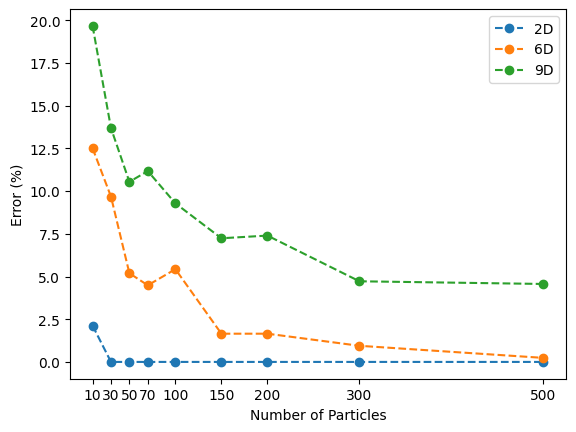

In [15]:
#| label: fig-error_population_size
#| fig-cap: 'PSO error v.s. population size in 2D, 6D and 9D Rastrigin function'

fig, ax = plt.subplots()
fig = plt.plot(population, error_2D, '--o', label='2D')
fig = plt.plot(population, error_6D, '--o', label='6D')
fig = plt.plot(population, error_9D, '--o', label='9D')
plt.legend()
plt.xlabel('Number of Particles')
plt.ylabel('Error (%)')
plt.xticks(population)
plt.show()

Based on the @fig-error_population_size, we can observe that the error rate decreases with an increase in population size. However, as the complexity of the objective function increases, the improvement in error rate by increasing the population size is not as significant as it is with a low population size. For instance, in a 9D Rastrigin function, increasing the population size from 300 to 500 results in an error rate improvement of only about 1%. On the other hand, when we increase the population size from 10 to 200, we can see an improvement of approximate 10% in the error rate.

After conducting the benchmark test, we concluded that the optimal population size for PSO is 200. If the population size exceeds this limit, say goes beyond 200, the computation cost increases but the performance improvement is not significant.
